# 3. Régressions linéaires

Maintenant que nous avons décrit les variables ainsi que leurs relations entre elles. Il est intéressant de faire une régression afin de fournir un début d'explication sur l'effet des variables socio-démographiques sur la position des trotinettes. Nous allons ainsi faire deux régressions, une sur l'ensemble des trotinettes en fonction des données des quartiers et de leur distance à un moyen de transport. Et autre à un niveau agrégé pour expliquer le nombre de trotinette dans un quartier en fonction de ses spécificités

## 3.1 Préparation des données

Les base telles qu'elles sont ne permettent pas de pouvoir faire des régressions, notamment parce que des variables sont qualitatives. De plus, il faut pour pouvoir utiliser la distance aux moyens de transport créer différentes catégories en fonction de leurs distances.

In [103]:
path="/Users/dalilyoucefi/Documents/ProjetInfo/"

In [104]:
import pandas as pd
import plotly.express as px
from scipy.stats import pearsonr
import plotly.graph_objects as go
from scipy.stats import chi2_contingency as chi2_contingency
from scipy.stats import pearsonr
import geopandas as gpd

In [105]:
df = pd.read_csv(path+'BaseQuartierLuSa.csv')
gdf = gpd.read_file(path+'GeoTierLunsSA.geojson')



On regarde comment se répartit la distance aux moyens de transport

In [106]:
gdf["min_distance"].min()

0.002546362541187594

In [107]:
gdf["min_distance"].quantile(0.5)

0.20971384983506855

In [108]:
gdf["min_distance"]

0        0.238695
1        0.085875
2        0.086848
3        0.051079
4        0.335544
           ...   
32067    0.194821
32068    0.281159
32069    0.281159
32070    0.297171
32071    0.297171
Name: min_distance, Length: 32072, dtype: float64

On crée plusieurs tranches de distance aux moyens de transport

In [109]:
li=[]

for i in range(len(gdf)):
    if gdf["min_distance"][i]<0.05:
        li.append("0-50")
    if gdf["min_distance"][i]>=0.05 and gdf["min_distance"][i]<0.1:
        li.append("50-100")
    if gdf["min_distance"][i]>=0.1 and gdf["min_distance"][i]<0.15:
        li.append("100-150")
    if gdf["min_distance"][i]>=0.15 and gdf["min_distance"][i]<0.2:
        li.append("150-200")
    if gdf["min_distance"][i]>=0.2 and gdf["min_distance"][i]<0.25:
        li.append("200-250")
    if gdf["min_distance"][i]>=0.25 and gdf["min_distance"][i]<0.3:
        li.append("250-300")
    if gdf["min_distance"][i]>=0.3 and gdf["min_distance"][i]<0.35:
        li.append("300-350")
    if gdf["min_distance"][i]>=0.35 and gdf["min_distance"][i]<0.4:
        li.append("350-400")
    if gdf["min_distance"][i]>=0.4 and gdf["min_distance"][i]<0.45:
        li.append("400-450")
    if gdf["min_distance"][i]>=0.45 and gdf["min_distance"][i]<0.5:
        li.append("450-500")
    if gdf["min_distance"][i]>=0.5:
        li.append("500+")

In [110]:
gdf["dist_transport"]=li

In [111]:
gdf.min_distance

0        0.238695
1        0.085875
2        0.086848
3        0.051079
4        0.335544
           ...   
32067    0.194821
32068    0.281159
32069    0.281159
32070    0.297171
32071    0.297171
Name: min_distance, Length: 32072, dtype: float64

In [112]:
gdf.dist_transport

0        200-250
1         50-100
2         50-100
3         50-100
4        300-350
          ...   
32067    150-200
32068    250-300
32069    250-300
32070    250-300
32071    250-300
Name: dist_transport, Length: 32072, dtype: object

On compte le nombre de trotinnette en fonction du quartier où elles se trouvent, du jour et de l'heure et de la distance au moyen de transport.

In [113]:
gdf2=gdf[["ID","dist_transport","id_quartier","Heure","Jour"]].groupby(["dist_transport","id_quartier","Heure","Jour"],as_index=False).count()


In [114]:
gdf2

,dist_transport,id_quartier,Heure,Jour,ID
0,0-50,1,14h,Lundi,3
1,0-50,1,19h,Lundi,1
2,0-50,1,19h,Samedi,1
3,0-50,1,9h,Lundi,3
4,0-50,1,9h,Samedi,1
...,...,...,...,...,...
4876,500+,79,18h,Samedi,2
4877,500+,79,19h,Lundi,2
4878,500+,79,19h,Samedi,2
4879,500+,79,9h,Lundi,3


In [115]:
df.columns

Index(['Unnamed: 0', 'Jour', 'c_qu', 'l_qu', 'prop_0-14', 'prop_15-29',
       'prop_30-44', 'prop_45-59', 'prop_60-74', 'prop_75+', 'nombre_0-14',
       'nombre_15-29', 'nombre_30-44', 'nombre_45-59', 'nombre_60-74',
       'nombre_75+', 'pop', 'densite', 'nombretransport', 'numquartier', 'ref',
       'nb_logmt_total', 'nombre_de_commerce', 'nombreent', 'CA 1',
       'nombretrottotal'],
      dtype='object')

On garde 

In [116]:
 for i in range(len(df)):
   
    if df["Jour"][i]=="Lundi":
        df["Jour"]=0
    else:
        df["Jour"]=1


In [117]:
df["numquartier"]=df["numquartier"].astype(str)


In [118]:
df2=df[[ "numquartier", 
        'nombre_0-14',
       'nombre_15-29', 'nombre_30-44', 'nombre_45-59', 'nombre_60-74', 'nombre_75+',
       'nombretransport', 'ref', 'nb_logmt_total',
       'nombre_de_commerce', 'nombreent', 'CA 1']]

In [119]:
gdf2=gdf2.merge(df2, left_on="id_quartier",right_on="numquartier")

In [120]:
for i in range (len(gdf2)): 
    gdf2["Heure"][i]=gdf2["Heure"][i].replace('h','')
for i in range(len(df)):
   
    if gdf2["Jour"][i]=="Lundi":
        gdf2["Jour"]=0
    else:
        gdf2["Jour"]=1
gdf2["Heure"]=gdf2["Heure"].astype(int)
       

/Users/dalilyoucefi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [121]:
gdf2['dist_transport'] = gdf2['dist_transport'].astype('category')
gdf2['dist_transport'] = gdf2['dist_transport'].cat.reorder_categories(['0-50', '100-150', '150-200', '200-250', '250-300', '300-350',
       '350-400', '400-450', '450-500', '50-100', '500+'], ordered=True)
gdf2['dist_transport'] = gdf2['dist_transport'].cat.codes

## 3.2 Régressions

In [144]:
Y = pd.DataFrame(gdf2["ID"])
X= gdf2[['dist_transport', 'Heure', 'Jour', 'nombre_0-14',
       'nombre_15-29', 'nombre_30-44', 'nombre_45-59', 'nombre_60-74', 'nombre_75+',
       'nombretransport', 'ref', 'nb_logmt_total', 'nombre_de_commerce',
       'nombreent', 'CA 1']]

In [145]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

regr = linear_model.LinearRegression() # Do not use fit_intercept = False if you have removed 1 column after dummy encoding
regr.fit(X_train, Y_train)
predicted = regr.predict(X_test)


In [146]:
regr.coef_

array([[-3.24954429e-01,  9.39893870e-03, -3.45804928e-15,
        -5.56591975e-04, -1.02085248e-04,  2.37936918e-05,
         9.91541932e-05,  2.54234317e-04,  3.80934256e-04,
         2.22023017e-01, -2.61025699e-02,  4.90611721e-04,
         4.44996240e-02,  8.99204283e-04, -1.35206401e-08]])

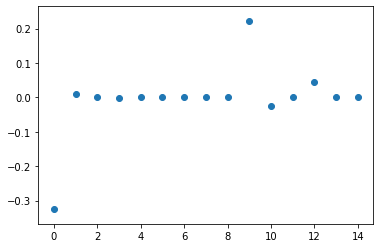

In [147]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter([i for i in range(len(regr.coef_[0]))],regr.coef_[0])
plt.show()

In [152]:
Y=pd.DataFrame(df["nombretrottotal"])
X=df[[ "Jour",'nombre_60-74', 'nombre_75+', 'nombretransport', 'ref', 'nombre_de_commerce', 'nombreent', 'CA 1']]

In [153]:
regr = linear_model.LinearRegression() 
regr.fit(X_train, Y_train)
predicted = regr.predict(X_test)

In [154]:
regr.coef_

array([[ 0.00000000e+00, -1.50288490e-02, -4.11723454e-03,
        -1.02792991e-04, -6.53573874e-03,  2.19532224e-02,
         1.43336143e-02,  8.26434701e+00, -9.42142900e+00,
         2.01655477e+00,  6.42758615e-02, -6.05739813e-07]])

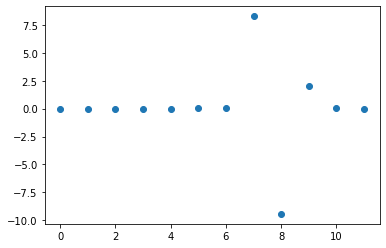

In [155]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter([i for i in range(len(regr.coef_[0]))],regr.coef_[0])
plt.show()

In [159]:
!pip install statsmodels

In [160]:
import statsmodels.api as sm
model = sm.OLS(Y,X)
results = model.fit()
results.params

Jour                  3.611485e+02
nombre_0-14          -1.542486e-02
nombre_15-29         -4.984078e-03
nombre_30-44          1.263024e-03
nombre_45-59         -8.415262e-03
nombre_60-74          2.254610e-02
nombre_75+            1.545379e-02
nombretransport       9.209974e+00
ref                  -1.053811e+01
nombre_de_commerce    2.005148e+00
nombreent             5.161326e-02
CA 1                 -6.755690e-07
dtype: float64

In [162]:
results.tvalues

Jour                  1.891716
nombre_0-14          -1.668507
nombre_15-29         -0.648207
nombre_30-44          0.154275
nombre_45-59         -0.362618
nombre_60-74          0.949526
nombre_75+            1.646941
nombretransport       3.008788
ref                  -1.597176
nombre_de_commerce    3.360935
nombreent             2.362939
CA 1                 -1.656450
dtype: float64

ValueError: wrong shape for coefs